<a href="https://colab.research.google.com/github/CelikAbdullah/deep-learning-notebooks/blob/main/Deep%20Reinforcement%20Learning/Value%20Based/Dueling%20DDQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym
import time
import random
from matplotlib import pyplot as plt
from itertools import count
import os
import imageio
import PIL.ImageDraw as ImageDraw
from PIL import Image as Im
from IPython import display

# Dueling Q Network

At this step, we define the dueling Q-network. The following Q network is different from the one we used in DQN and DDQN. It will have two separate estimators, one of the state-value function $V(s)$ and the other of the action-advantage function $A(s,a)$.

In [2]:
class DuelingQNetwork(nn.Module):
  def __init__(self,
               input_dim,
               output_dim,
               hidden_dims=(32,32),
               activation_fc=F.relu):
    super(DuelingQNetwork, self).__init__()
    self.activation_fc = activation_fc

    # input layer
    self.input_layer = nn.Linear(input_dim, hidden_dims[0])

    # hidden layer(s)
    self.hidden_layers = nn.ModuleList()
    for i in range(len(hidden_dims)-1):
      hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
      self.hidden_layers.append(hidden_layer)

    # value of the given state
    self.value_output = nn.Linear(hidden_dims[-1], 1)
    # action-advantage output
    self.advantage_output = nn.Linear(hidden_dims[-1], output_dim)

    device = "cpu"
    if torch.cuda.is_available():
      device = "cuda:0"

    self.device = torch.device(device)
    self.to(self.device)

  def _format(self, state):
    x = state
    if not isinstance(x, torch.Tensor):
      x = torch.tensor(x, device=self.device, dtype=torch.float32)
      x = x.unsqueeze(0)
    return x

  def forward(self, state):
    x = self._format(state)
    x = self.activation_fc(self.input_layer(x))
    for hidden_layer in self.hidden_layers:
      x = self.activation_fc(hidden_layer(x))

    # approximate the action-advantage function
    a = self.advantage_output(x)
    # approximate the state-value function
    v = self.value_output(x)

    # expand v since it's a single value that will be added to 'a'
    v = v.expand_as(a)

    # put approximated action-advantage & state-value functions together
    # to estimate the Q values
    q = v + a - a.mean(1, keepdim=True).expand_as(a)

    return q

  def numpy_float_to_device(self, variable):
    variable = torch.from_numpy(variable).float().to(self.device)
    return variable

  def load(self, experiences):
    states, actions, new_states, rewards, is_terminals = experiences
    states = torch.from_numpy(states).float().to(self.device)
    actions = torch.from_numpy(actions).long().to(self.device)
    new_states = torch.from_numpy(new_states).float().to(self.device)
    rewards = torch.from_numpy(rewards).float().to(self.device)
    is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
    return states, actions, new_states, rewards, is_terminals

# Replay Buffer

The replay buffer is a data structure that allows us to implement a technique called **experience replay**. It holds experience samples for several timesteps so that we can sample mini-batches of experiences.

The main benefit of using a replay buffer: the samples (experiences) we pass to the network appear independent and identically distributed which in turn stabilize the optimization process.

The idea behind experience replay is very straightforward:
During training, we collect experiences and store them into the replay buffer. After enough experiences are collected, we then sample a mini-batch of a certain size from the buffer and pass it to the network.

In [3]:
class ReplayBuffer():

  # our replay buffer has a default max size of 50000 and uses a batch size of 64
  def __init__(self, max_size=10000,
               batch_size=64):

    # initialize five empty NumPy arrays that will hold states, actions, rewards, next_states and done flags
    self.ss_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.as_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.rs_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.ps_mem = np.empty(shape=(max_size), dtype=np.ndarray)
    self.ds_mem = np.empty(shape=(max_size), dtype=np.ndarray)

    self.max_size = max_size
    self.batch_size = batch_size
    self._idx = 0
    self.size = 0

  def store(self, experience):
    '''
    Store the components of the experience into the corresponding NumPy array.
    '''
    # unwrap the experience which is just a tuple
    s, a, r, p, d = experience

    # store each component to its corresponding NumPy array
    self.ss_mem[self._idx] = s
    self.as_mem[self._idx] = a
    self.rs_mem[self._idx] = r
    self.ps_mem[self._idx] = p
    self.ds_mem[self._idx] = d

    # adjust the index
    self._idx += 1

    # if the replay buffer is full, we wrap around and overwrite older experiences with new ones
    self._idx = self._idx % self.max_size

    # adjust the size
    self.size += 1
    # determine the size
    self.size = min(self.size, self.max_size)

  def sample(self, batch_size=None):
    '''
    Sample a mini-batch of experiences from the replay buffer.
    '''
    if batch_size == None:
      batch_size = self.batch_size

    # Generate a uniform random sample from np.arange(self.size) of size 'batch_size' without replacement:
    idxs = np.random.choice(self.size, batch_size, replace=False)

    # create the mini-batch of experiences
    mini_batch_experiences = np.vstack(self.ss_mem[idxs]), \
                             np.vstack(self.as_mem[idxs]), \
                             np.vstack(self.rs_mem[idxs]), \
                             np.vstack(self.ps_mem[idxs]), \
                             np.vstack(self.ds_mem[idxs])

    return mini_batch_experiences

  def __len__(self):
    return self.size

# Exploration strategies

The GreedyStrategy will always select the maximum Q-value.

In [4]:
# the strategy we will use in the evaluation phase
class GreedyStrategy():

  def select_action(self, model, state):
    with torch.no_grad():
      # get the q-value of each action given the state
      q_values = model(state).cpu().detach().data.numpy().squeeze()

      # return the index of the action with the highest estimate
      return np.argmax(q_values)

The exponential $\epsilon$-greedy strategy a decaying epsilon value so that the probability of exploration is higher at the beginning and the probability of exploitation is higher at the end of the training phase.

In [5]:
# the strategy we will use in the training phase
class EGreedyExpStrategy():
  '''
  In the exponentially decaying strategy, the epsilon value is decaying in an exponential curve.
  '''

  def __init__(self, init_epsilon=1.0, min_epsilon=0.1, decay_steps=20000):
    self.epsilon = init_epsilon
    self.init_epsilon = init_epsilon
    self.decay_steps = decay_steps
    self.min_epsilon = min_epsilon
    self.epsilons = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
    self.epsilons = self.epsilons * (init_epsilon - min_epsilon) + min_epsilon
    self.t = 0

  def _epsilon_update(self):
    self.epsilon = self.min_epsilon if self.t >= self.decay_steps else self.epsilons[self.t]
    self.t += 1

    return self.epsilon

  def select_action(self, model, state):
    with torch.no_grad():
      q_values = model(state).detach().cpu().data.numpy().squeeze()

    # we draw the random number from a uniform distribution and compare it to epsilon
    # if it is higher, we use the argmax of the q-values
    # otherwise, we use a random action
    if np.random.rand() > self.epsilon:
      action = np.argmax(q_values)
    else:
      action = np.random.randint(len(q_values))

    # adjust the epsilon value
    self._epsilon_update()

    return action

# DDQN agent with a dueling Q-network

We do the same as in DDQN. But this time, there are some improvements:


*   Update the target network using a technique called Polyak Averaging

    The idea behind this technique is that we are slowing down the target network instead of freezing it.
    To achieve that, we mix in online network weights into the target network on every step. Technically, we create a new target network composed of a large percentage of the target network weights and a small percentage of the online network weights, in every step

*   Use a dueling Q-network that we implemented previously

In [6]:
class DuelingDDQN():
  def __init__(self,
               env,
               seed,
               online_model,
               target_model,
               replay_buffer,
               optimizer,
               training_strategy,
               evaluation_strategy,
               max_gradient_norm,
               tau,
               gamma,
               update_steps,
               max_episodes,
               goal,
               warmup_batches):

    # set the attributes
    self.env = env
    self.seed = seed
    self.online_model = online_model
    self.target_model = target_model
    self.replay_buffer = replay_buffer
    self.optimizer = optimizer
    self.training_strategy = training_strategy
    self.evaluation_strategy = evaluation_strategy
    self.max_gradient_norm = max_gradient_norm
    self.gamma = gamma
    self.update_steps = update_steps
    self.max_episodes = max_episodes
    self.goal = goal
    self.warmup_batches = warmup_batches
    self.tau = tau
    self.evaluation_scores = []
    self.mean_evaluation_scores = []

  def __update(self, tau=None):
    # determine the ratio of the online network that will be mixed
    # into the target network
    tau = self.tau if tau is None else tau

    # iterate throgh the weights
    for target, online in zip(self.target_model.parameters(),
                              self.online_model.parameters()):

      # determine the ratio we are taken from the target network
      target_ratio = (1.0 - tau) * target.data
      # detetermine the ration we are taken from online network
      online_ratio = tau * online.data
      # mix the weights of the online and target network
      mixed_weights = target_ratio + online_ratio
      # copy the mixed weights into the target network
      target.data.copy_(mixed_weights)



  def __interact(self, cur_state):
    # select an action according to the exponentially decaying epsilon-greedy exploration strategy
    action = self.training_strategy.select_action(self.online_model, cur_state)
    # perform the selected action in the environment
    next_state, reward, is_terminal, info = env.step(action)
    # determine if CartPole's built-in TimeLimit is reached
    is_truncated = 'TimeLimit.truncated' in info and info['TimeLimit.truncated']
    # calculate the is_failure flag indicating a terminal state
    is_failure = is_terminal and not is_truncated
    # create the experience
    experience = (cur_state, action, reward, next_state, float(is_failure))

    return experience, next_state, is_terminal


  def __optimize(self, experiences):
    # extract the experience components
    states, actions, rewards, next_states, is_terminals = experiences
    batch_size = len(is_terminals)
    # query the online network to get the index of the highest-valued
    # action of the next state
    index_of_highest_valued_q_values = self.online_model(next_states).max(dim=1)[1]
    # query the q values of the next state according to target network
    q_values_of_target_network = self.target_model(next_states).detach()
    # index the Q values given by the target network
    # with the action indices given be the online network
    highest_valued_q_values = q_values_of_target_network[np.arange(batch_size), index_of_highest_valued_q_values].unsqueeze(1)
    # create the target values
    target_q_values = rewards + (self.gamma * highest_valued_q_values * (1-is_terminals))
    # get the current estimates
    predicted_q_values = self.online_model(states).gather(dim=1, index=actions)
    # determine the loss
    loss = (predicted_q_values - target_q_values).pow(2).mul(0.5).mean()
    # zero-out the gradients
    self.optimizer.zero_grad()
    # compute the gradients
    loss.backward()
    # to implement the Huber loss, we compute the MSE loss (as above) and
    # now we set the all gradients larger than a threshold to a fixed magnitude
    # value; so we clip the magnitude of the gradients
    torch.nn.utils.clip_grad_norm_(self.online_model.parameters(),
                                   self.max_gradient_norm)
    # update the weights
    self.optimizer.step()


  def __evaluate(self, episodes=1):
    # keep a list of the rewards
    rewards = []
    # for each episode
    for _ in range(episodes):
      # get the initial state
      state = self.env.reset(seed=self.seed)
      # set 'is_terminal' flag to False
      is_terminal = False
      # initialize the rewards list
      rewards.append(0)
      # for each timestep in the current episode
      for _ in count():
        # get the action according to evaluation strategy from the online_model
        action = self.evaluation_strategy.select_action(self.online_model, state)
        # perform the action in the environment
        state, reward, is_terminal, _ = self.env.step(action)
        # save the experienced reward
        rewards[-1] += reward
        # break if we are in a terminal state
        if is_terminal:
          break

    # return the mean of the rewards
    return np.mean(rewards)

  def __sample(self):
    # sample a mini-batch of experiences from the replay buffer
    experiences = self.replay_buffer.sample()
    # invoke the load() method which extracts the components of each experience
    # transforms them into a PyTorch tensor, and loads them onto the current device (cpu or gpu)
    experiences = self.online_model.load(experiences)

    return experiences


  def train(self):
    # make sure that online and target network have the same weights before training starts
    self.__update(tau=1.0)

    # for each episode
    for episode in range(self.max_episodes):
      cur_state = self.env.reset(seed=self.seed)    # get the initial state
      is_terminal = False        # flag indicating whether episode is finished or not
      episode_timestep = 0   # initialize list to hold the number of timesteps

      # for each timestep in the current episode
      for timestep in count():
        # interact with the environment
        experience, new_state, is_terminal = self.__interact(cur_state)
        # adjust the timestep so that we know when to update the target network
        episode_timestep += 1
        # store the experience into the replay buffer
        replay_buffer.store(experience)
        # update current state
        cur_state = new_state

        # check if we have enough experiences in the replay buffer
        if len(replay_buffer) > self.replay_buffer.batch_size * self.warmup_batches:
          # get a minibatch of experiences from the replay buffer
          experiences = self.__sample()

          # OPTIMIZATION STEP
          # optimize the model
          self.__optimize(experiences)


        # update the weights of the target network periodically
        if episode_timestep % self.update_steps == 0:
          # UPDATE step
          # make sure that online and target network have the same weights
          self.__update()

        # break if current state was a terminal state
        if is_terminal:
          break


      # EVALUATION step (optional)
      # compute the evaluation score
      evaluation_score = self.__evaluate()
      # store the evaluation score
      self.evaluation_scores.append(evaluation_score)
      # comput the mean evaluation score
      mean_100_eval_score = np.mean(self.evaluation_scores[-100:])
      self.mean_evaluation_scores.append(mean_100_eval_score)
      print(f"Episode: {episode}, Timestep: {episode_timestep}, Evaluation score: {evaluation_score}, Mean evaluation score: {mean_100_eval_score}")

      # flag indicating whether max episodes is reached
      reached_max_episodes = episode >= self.max_episodes
      # flag indicating whether mean goal reward is reached
      reached_goal_mean_reward = mean_100_eval_score >= self.goal

      # finish if one of the flags is true
      training_is_over = reached_max_episodes or reached_goal_mean_reward
      if training_is_over:
        if reached_max_episodes: print('Max episodes are reached')
        if reached_goal_mean_reward: print('Goal mean reward is reached')
        break



    # get the final evaluation score
    final_evaluation_score = self.__evaluate(episodes=100)
    print(f"Final evaluation score: {final_evaluation_score}")

    self.env.close()
    del self.env

# CartPole environment

## Train the Dueling DDQN agent

In [28]:
# define the our discount factor
gamma = 1.0
# number of steps when to update the target network
update_steps = 10
# define nr. of max episodes
max_episodes = 10000
# define mean reward value
goal = 475
# warmup batches
warmup_batches = 5
# define the max gradient norm
max_gradient_norm = float('inf')
# define the learning rate
lr = 0.0005
# define tau for the update step
tau = 0.1
# define the seed value
seed = 42

# create an instance of the environment
env = gym.make("CartPole-v1")
# create an instance of the replay buffer
replay_buffer = ReplayBuffer(max_size=50000, batch_size=64)
# define our action-selection policy for the training phase
training_strategy = EGreedyExpStrategy(init_epsilon=1.0, min_epsilon=0.3, decay_steps=20000)
# define our action-selection policy for the evaluation phase
evaluation_strategy = GreedyStrategy()
# define the state space
state_space = env.observation_space.shape[0]
# define the action space
action_space = env.action_space.n
# build the online network
online_model = DuelingQNetwork(state_space, action_space, hidden_dims=(512,128))
# build the target network
target_model = DuelingQNetwork(state_space, action_space, hidden_dims=(512,128))
# create an instance of the RMSprop optimizer
optimizer = optim.RMSprop(online_model.parameters(), lr=lr)
# create the DQN agent
dueling_ddqn_agent = DuelingDDQN(env,
                                 seed,
                                 online_model,
                                 target_model,
                                 replay_buffer,
                                 optimizer,
                                 training_strategy,
                                 evaluation_strategy,
                                 max_gradient_norm,
                                 tau,
                                 gamma,
                                 update_steps,
                                 max_episodes,
                                 goal,
                                 warmup_batches
                                 )

# let the Dueling DDQN agent train
dueling_ddqn_agent.train()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode: 0, Timestep: 20, Evaluation score: 8.0, Mean evaluation score: 8.0
Episode: 1, Timestep: 14, Evaluation score: 8.0, Mean evaluation score: 8.0
Episode: 2, Timestep: 19, Evaluation score: 8.0, Mean evaluation score: 8.0
Episode: 3, Timestep: 52, Evaluation score: 8.0, Mean evaluation score: 8.0
Episode: 4, Timestep: 18, Evaluation score: 8.0, Mean evaluation score: 8.0
Episode: 5, Timestep: 15, Evaluation score: 8.0, Mean evaluation score: 8.0
Episode: 6, Timestep: 27, Evaluation score: 8.0, Mean evaluation score: 8.0
Episode: 7, Timestep: 37, Evaluation score: 8.0, Mean evaluation score: 8.0
Episode: 8, Timestep: 17, Evaluation score: 8.0, Mean evaluation score: 8.0
Episode: 9, Timestep: 22, Evaluation score: 8.0, Mean evaluation score: 8.0
Episode: 10, Timestep: 17, Evaluation score: 8.0, Mean evaluation score: 8.0
Episode: 11, Timestep: 20, Evaluation score: 8.0, Mean evaluation score: 8.0
Episode: 12, Timestep: 12, Evaluation score: 8.0, Mean evaluation score: 8.0
Episode: 

## Save model

In [29]:
torch.save(dueling_ddqn_agent.online_model.state_dict(), "/content/drive/MyDrive/Dueling DDQN/DuelingDDQN_agent_cartpole.pt")

## Visualize

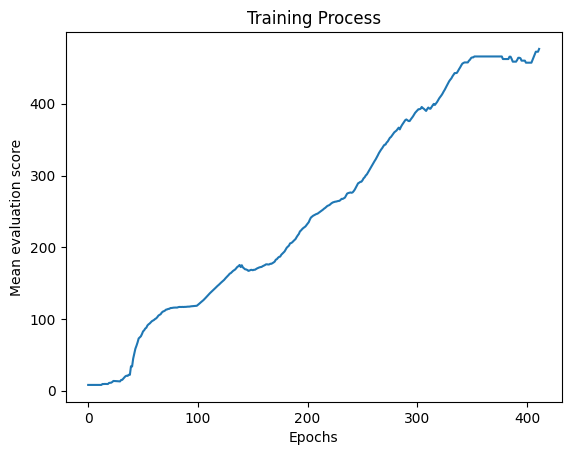

In [30]:
plt.plot(dueling_ddqn_agent.mean_evaluation_scores)
plt.xlabel("Epochs")
plt.ylabel("Mean evaluation score")
plt.title("Training Process")
plt.show()

In [31]:
env = gym.make("CartPole-v1")
model = DuelingQNetwork(env.observation_space.shape[0], env.action_space.n, hidden_dims=(512,128))
model.load_state_dict(torch.load("/content/drive/MyDrive/Dueling DDQN/DuelingDDQN_agent_cartpole.pt"))
model.eval()

DuelingQNetwork(
  (input_layer): Linear(in_features=4, out_features=512, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=512, out_features=128, bias=True)
  )
  (value_output): Linear(in_features=128, out_features=1, bias=True)
  (advantage_output): Linear(in_features=128, out_features=2, bias=True)
)

In [34]:
def create_gif(env, episodes):
  # list to keep track of frames
  frames = []

  for episode in range(1, episodes + 1):
    # select a seed value randomly
    seed = random.randint(0,20)

    # get the initial state
    state = env.reset(seed=seed)

    # for each timestep, do the following
    for t in range(500):
      # get the Q-value estimates
      q_values = model(state)
      # select the action (greedily)
      action = np.argmax(q_values.data.numpy())

      # get the frame & store it
      frame = env.render(mode='rgb_array')

      # prepare the frame
      im = Im.fromarray(frame)
      drawer = ImageDraw.Draw(im)
      if np.mean(im) < 128:
        text_color = (255,255,255)
      else:
        text_color = (0,0,0)
        drawer.text((im.size[0]/20,im.size[1]/18), f'Episode: {episode}', fill=text_color)
        drawer.text((im.size[0]/20,im.size[1]/8), f'Timestep: {t+1}', fill=text_color)

      # store the frame
      frames.append(im)

      # take the action in the environment
      state, _, is_terminal, _ = env.step(action)

      # if we land at a terminal state, break
      if is_terminal:
        break

    # close the environment
    env.close()

    # create the gif
    imageio.mimwrite(os.path.join('/content/drive/MyDrive/Gif/', 'DuelingDDQN_agent_cartpole.gif'), frames, duration=20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
episodes = 5
env = gym.make('CartPole-v1')
create_gif(env, episodes)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


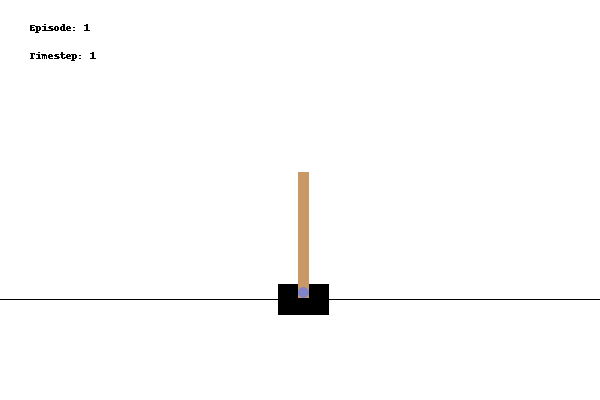

In [36]:
display.Image(open('/content/drive/MyDrive/Gif/DuelingDDQN_agent_cartpole.gif','rb').read())

## LunarLander environment

We have to install some dependencies before we can use the LunarLander environment.

In [8]:
!pip install -q swig

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.6 MB/s eta 0:00:00


In [9]:
!pip install -q gym[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 64.6 MB/s eta 0:00:00


## Train the Dueling DDQN agent

In [10]:
# define the our discount factor
gamma = 0.99
# number of steps when to update the target network
update_steps = 10
# define nr. of max episodes
max_episodes = 10000
# define mean reward value
goal = 200
# warmup batches
warmup_batches = 5
# define the max gradient norm
max_gradient_norm = float('inf')
# define the learning rate
lr = 0.0005
# define tau for the update step
tau = 0.1
# define the seed value
seed = 42
# create an instance of the environment
env = gym.make("LunarLander-v2")
# create an instance of the replay buffer
replay_buffer = ReplayBuffer(max_size=100000, batch_size=128)
# define our action-selection policy for the training phase
training_strategy = EGreedyExpStrategy(init_epsilon=1.0, min_epsilon=0.3, decay_steps=20000)
# define our action-selection policy for the evaluation phase
evaluation_strategy = GreedyStrategy()
# define the state space
state_space = env.observation_space.shape[0]
# define the action space
action_space = env.action_space.n
# build the online network
online_model = DuelingQNetwork(state_space, action_space, hidden_dims=(512,128))
# build the target network
target_model = DuelingQNetwork(state_space, action_space, hidden_dims=(512,128))
# create an instance of the RMSprop optimizer
optimizer = optim.Adam(online_model.parameters(), lr=lr)
# create the DQN agent
dueling_ddqn_agent = DuelingDDQN(env,
                                 seed,
                                 online_model,
                                 target_model,
                                 replay_buffer,
                                 optimizer,
                                 training_strategy,
                                 evaluation_strategy,
                                 max_gradient_norm,
                                 tau,
                                 gamma,
                                 update_steps,
                                 max_episodes,
                                 goal,
                                 warmup_batches
                                 )

# let the Dueling DDQN agent train
dueling_ddqn_agent.train()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode: 0, Timestep: 100, Evaluation score: -565.9570103877534, Mean evaluation score: -565.9570103877534
Episode: 1, Timestep: 126, Evaluation score: -565.9570103877534, Mean evaluation score: -565.9570103877534
Episode: 2, Timestep: 108, Evaluation score: -565.9570103877534, Mean evaluation score: -565.9570103877534
Episode: 3, Timestep: 108, Evaluation score: -565.9570103877534, Mean evaluation score: -565.9570103877534
Episode: 4, Timestep: 106, Evaluation score: -565.9570103877534, Mean evaluation score: -565.9570103877534
Episode: 5, Timestep: 112, Evaluation score: -734.4294158000397, Mean evaluation score: -594.0357446231344
Episode: 6, Timestep: 126, Evaluation score: -734.4294158000397, Mean evaluation score: -614.0919833626923
Episode: 7, Timestep: 93, Evaluation score: -734.4294158000397, Mean evaluation score: -629.1341624173607
Episode: 8, Timestep: 127, Evaluation score: -661.101561617308, Mean evaluation score: -632.6860956617993
Episode: 9, Timestep: 113, Evaluation s

## Save the model

In [11]:
torch.save(dueling_ddqn_agent.online_model.state_dict(), "/content/drive/MyDrive/DDQN/DDQN_agent_lunarlander.pt")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Load the model

In [12]:
env = gym.make("LunarLander-v2")
model = DuelingQNetwork(env.observation_space.shape[0], env.action_space.n, hidden_dims=(512,128))
model.load_state_dict(torch.load("/content/drive/MyDrive/DDQN/DDQN_agent_lunarlander.pt"))
model.eval()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


DuelingQNetwork(
  (input_layer): Linear(in_features=8, out_features=512, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=512, out_features=128, bias=True)
  )
  (value_output): Linear(in_features=128, out_features=1, bias=True)
  (advantage_output): Linear(in_features=128, out_features=4, bias=True)
)

## Visualize

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


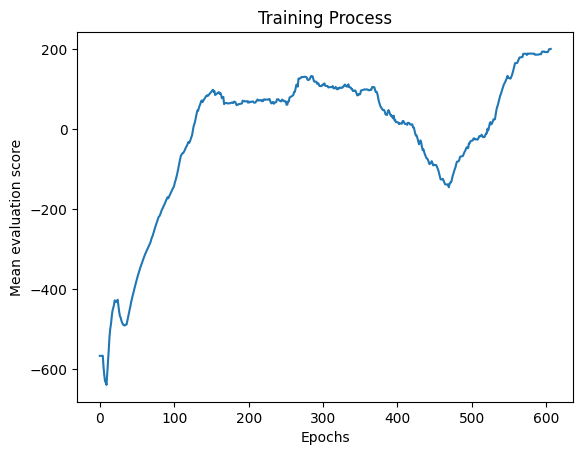

In [13]:
plt.plot(dueling_ddqn_agent.mean_evaluation_scores)
plt.xlabel("Epochs")
plt.ylabel("Mean evaluation score")
plt.title("Training Process")
plt.show()

In [21]:
def create_gif(env, episodes):
  # list to keep track of frames
  frames = []

  for episode in range(1, episodes + 1):
    # select a seed value randomly
    seed = random.randint(0,20)

    # get the initial state
    state = env.reset(seed = seed)

    # for each timestep, do the following
    for t in count():
      # get the Q-value estimates
      q_values = model(state)
      # select the action (greedily)
      action = np.argmax(q_values.data.numpy())

      # get the frame & store it
      frame = env.render(mode='rgb_array')

      # prepare the frame
      im = Im.fromarray(frame)
      drawer = ImageDraw.Draw(im)
      text_color = (255,255,255)
      drawer.text((im.size[0]/20,im.size[1]/18), f'Episode: {episode}', fill=text_color)
      drawer.text((im.size[0]/20,im.size[1]/8), f'Timestep: {t+1}', fill=text_color)

      # store the frame
      frames.append(im)

      # take the action in the environment
      state, _, is_terminal, _ = env.step(action)

      # if we land at a terminal state, break
      if is_terminal:
        break

    # close the environment
    env.close()

    # create the gif
    imageio.mimwrite(os.path.join('/content/drive/MyDrive/Gif/', 'dueling_ddqn_agent_lunarlander.gif'), frames, duration=20)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
episodes = 5
env = gym.make('LunarLander-v2')
create_gif(env, episodes)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


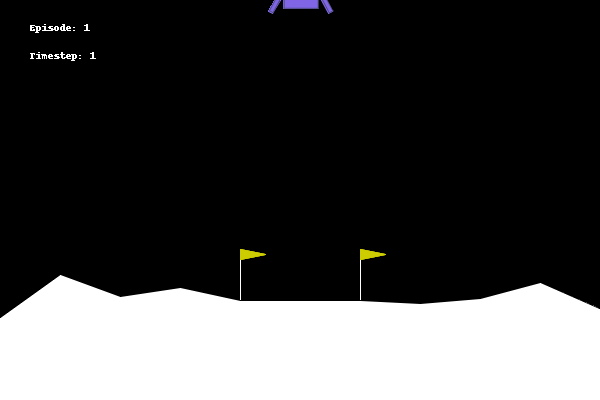

In [23]:
display.Image(open('/content/drive/MyDrive/Gif/dueling_ddqn_agent_lunarlander.gif','rb').read())